In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2

In [99]:
def create_dates(year, month, day):
    """
    This function returns date strings to retrieve 3-year data up to day defined by the date year-month-day. 

    Args:
        year: date argument
        month: date argument
        day: date argument
    
    Returns:
        list with end and start dates
    """

    if len(str(month)) == 1:
        month = str(0) + str(month)
    else:
        month = str(month)
    if len(str(day)) == 1:
        day = str(0) + str(day)
    else:
        day = str(day)

    fecha = str(year) + "-" + str(month) + "-" + str(day)
    fecha2 = str(pd.to_datetime(fecha) - pd.DateOffset(years = 3))[0:10]

    return [fecha, fecha2]

date_interval = create_dates(2021, 12, 31)

In [87]:
db_conn = psycopg2.connect(
   database = "accidents_smb", user = "dev", password = "dev", host = "127.0.0.1", port = "5432"
)

In [88]:
# 1. Select accidents where a motorcycle was involved
# 2. Select the vehicles (different from the motorcycle) involved in the accident
query = """
WITH moto_accidents AS (
    SELECT DISTINCT vehiculos.FORMULARIO FROM
    vehiculos
    JOIN siniestros ON siniestros.FORMULARIO = vehiculos.FORMULARIO
    WHERE substring(siniestros.FECHA_ACC, 1, 10) > '""" + date_interval[1] + """' AND
        substring(siniestros.FECHA_ACC, 1, 10) <= '""" + date_interval[0] + """' AND
        vehiculos.CLASE LIKE 'MOTOCICLETA'
)
SELECT siniestros.FORMULARIO, siniestros.CLASE_ACC, siniestros.GRAVEDAD, vehiculos.CLASE AS CLASE_VEH
FROM siniestros
JOIN moto_accidents ON moto_accidents.FORMULARIO = siniestros.FORMULARIO
JOIN vehiculos ON vehiculos.FORMULARIO = siniestros.FORMULARIO
WHERE vehiculos.CLASE NOT LIKE 'MOTOCICLETA'
"""
accidents1 = pd.read_sql(query, con = db_conn)

In [89]:
# 1. Select accidents where more than 1 motorcycle was involved
# 2. Select the motorcycles involved in the accident
query = """
WITH moto_accidents AS (
    SELECT vehiculos.FORMULARIO, COUNT(vehiculos.FORMULARIO) FROM
    vehiculos
    JOIN siniestros ON siniestros.FORMULARIO = vehiculos.FORMULARIO
    WHERE substring(siniestros.FECHA_ACC, 1, 10) > '""" + date_interval[1] + """' AND
        substring(siniestros.FECHA_ACC, 1, 10) <= '""" + date_interval[0] + """' AND
        vehiculos.CLASE LIKE 'MOTOCICLETA'
    GROUP BY vehiculos.FORMULARIO
    HAVING COUNT(vehiculos.FORMULARIO) > 1 
)
SELECT siniestros.FORMULARIO, siniestros.CLASE_ACC, siniestros.GRAVEDAD, vehiculos.CLASE AS CLASE_VEH
FROM siniestros
JOIN moto_accidents ON moto_accidents.FORMULARIO = siniestros.FORMULARIO
JOIN vehiculos ON vehiculos.FORMULARIO = siniestros.FORMULARIO
WHERE vehiculos.CLASE LIKE 'MOTOCICLETA'
"""
accidents2 = pd.read_sql(query, con = db_conn)

In [90]:
db_conn.close()

In [91]:
accidents3 = pd.concat(objs = [accidents1, accidents2], axis = 0)

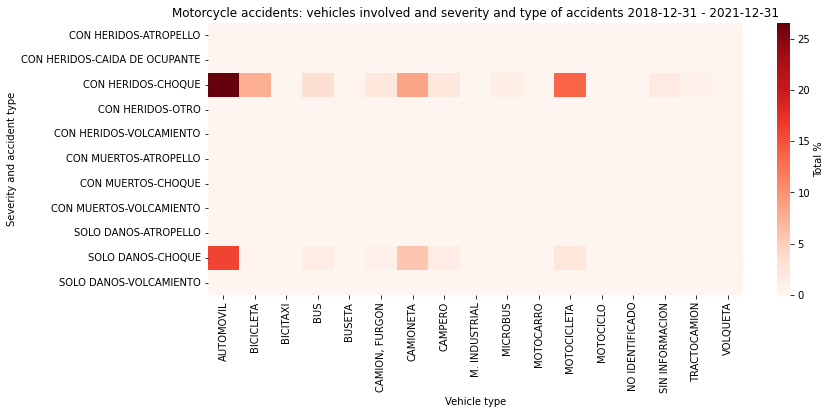

In [101]:
accidents_crosstab = pd.crosstab(index = [accidents3["gravedad"], accidents3["clase_acc"]], columns = accidents3["clase_veh"], \
    normalize = "all")*100
plt.figure(figsize = (12, 5))
sns.heatmap(accidents_crosstab, cmap = "Reds", cbar_kws = {"label": "Total %"})
#plt.tight_layout()
plt.title("Motorcycle accidents: vehicles involved and severity and type of accidents " + date_interval[1] + " - "  + \
    date_interval[0])
plt.xlabel("Vehicle type")
plt.ylabel("Severity and accident type")
#plt.savefig("crosstab_heatmap_rows.png")
plt.show()

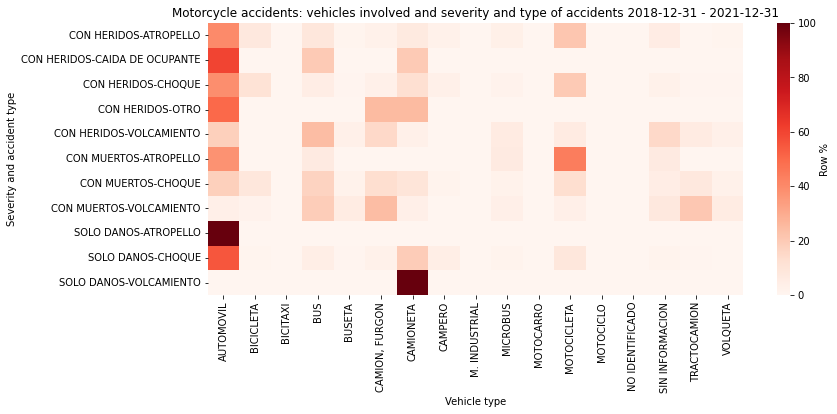

In [100]:
accidents_crosstab = pd.crosstab(index = [accidents3["gravedad"], accidents3["clase_acc"]], columns = accidents3["clase_veh"], \
    normalize = "index")*100
plt.figure(figsize = (12, 5))
sns.heatmap(accidents_crosstab, cmap = "Reds", cbar_kws= {"label": "Row %"})
#plt.tight_layout()
plt.title("Motorcycle accidents: vehicles involved and severity and type of accidents " + date_interval[1] + " - "  + \
    date_interval[0])
plt.xlabel("Vehicle type")
plt.ylabel("Severity and accident type")
#plt.savefig("crosstab_heatmap_rows.png")
plt.show()